In [328]:
import pandas as pd 
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors
import re
import seaborn as sns

In [329]:
from read_wandb import wandb_results
api = wandb_results("NLP2024_PROJECT_oribar18", wandb_username="oribar18")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [330]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=True, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric)
    df = df.iloc[:, :-40]

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = ['config_threshold_adjustment']
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]

    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])
    mean_df = grouped.mean()
    std_df = grouped.std()
    
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [331]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)
sweep_results = result_metric(["ppglbjo6", "v2r413kh", "zgk3tgnf", "5w7xx7qt", "tp2qakxf", "zcq9szvv"],'threshold_adjustment', drop_HPT=False, epoch='best')
sweep_results

Total number of sweeps: 6
Download sweep_id='ppglbjo6' data...
Download sweep_id='v2r413kh' data...
Download sweep_id='zgk3tgnf' data...
Download sweep_id='5w7xx7qt' data...
Download sweep_id='tp2qakxf' data...
Download sweep_id='zcq9szvv' data...
['config_threshold_adjustment']


C:\Users\oriba\AppData\Local\Temp\ipykernel_10676\4075747387.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
C:\Users\oriba\AppData\Local\Temp\ipykernel_10676\4075747387.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
C:\Users\oriba\AppData\Local\Temp\ipykernel_10676\407

,mean,std,values,epoch,CI
threshold_adjustment,,,,,
0.01,0.827410,0.001354,"[0.8268966008713108, 0.8263875068487594, 0.828...",6,"(0.8263875068487594, 0.8289452001568377)"
0.03,0.827062,0.002390,"[0.8298089779951844, 0.8259198275923579, 0.825...",8,"(0.8254585964225357, 0.8298089779951844)"


# Line chart value vs epoch

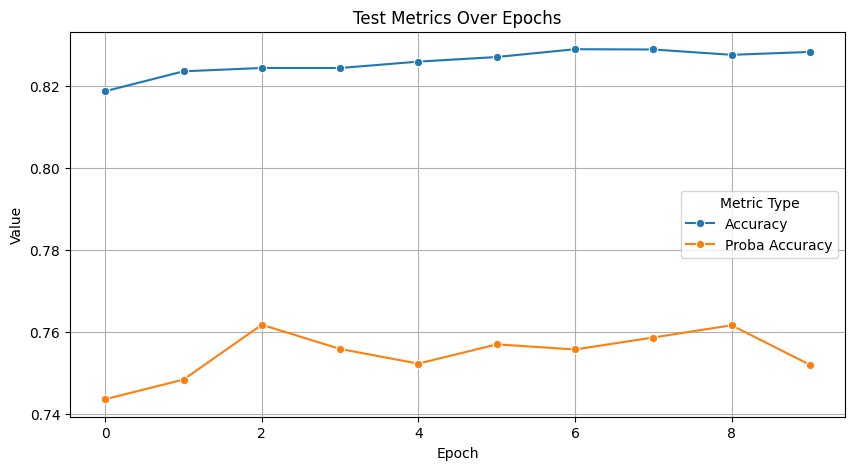

Max value for Accuracy: 0.829 at epoch 7
Max value for Proba Accuracy: 0.762 at epoch 3


In [332]:
# Initialize the W&B API
api = wandb.Api()

# Fetch the specific run
run = api.run("oribar18/NLP2024_PROJECT_oribar18/dwmafrr2")

# Get the summary metrics
metrics = run.summary

# Filter and organize metrics that contain "ENV_Test_accuracy_per_mean_user_and_bot_epoch" and "ENV_Test_proba_accuracy_per_mean_user_and_bot_epoch"
pattern_accuracy = re.compile(r"ENV_Test_accuracy_per_mean_user_and_bot_epoch(\d+)")
pattern_proba = re.compile(r"ENV_Test_proba_accuracy_per_mean_user_and_bot_epoch(\d+)")
data = []

for key, value in metrics.items():
    match_accuracy = pattern_accuracy.match(key)
    match_proba = pattern_proba.match(key)
    if match_accuracy:
        epoch = int(match_accuracy.group(1))
        data.append((epoch, 'Accuracy', value))
    elif match_proba:
        epoch = int(match_proba.group(1))
        data.append((epoch, 'Proba Accuracy', value))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["epoch", "type", "value"])

# Plot the data using seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="epoch", y="value", hue="type", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Test Metrics Over Epochs")
plt.grid(True)
plt.legend(title="Metric Type")
plt.show()

# Find and print the max value for each type
for metric_type in df['type'].unique():
    filtered_df = df[df['type'] == metric_type]
    max_row = filtered_df.loc[filtered_df['value'].idxmax()]
    print(f"Max value for {metric_type}: {max_row['value']:.03} at epoch {max_row['epoch']+1}")